<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import dataset</a></span></li><li><span><a href="#Embeddings-CTNet" data-toc-modified-id="Embeddings-CTNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embeddings CTNet</a></span></li><li><span><a href="#Modificar-modelo-para-sacar-cosas" data-toc-modified-id="Modificar-modelo-para-sacar-cosas-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modificar modelo para sacar cosas</a></span></li><li><span><a href="#One-graph-embedding" data-toc-modified-id="One-graph-embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>One graph embedding</a></span></li><li><span><a href="#All-graphs-embedding" data-toc-modified-id="All-graphs-embedding-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>All graphs embedding</a></span></li><li><span><a href="#DIGL" data-toc-modified-id="DIGL-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DIGL</a></span></li></ul></div>

Para CTNet, MinCutNet, GapNet and DIGL (4 figuras de cada task): 
- [ ] Embeddings de un grafo solo *conv2* -> dispersión
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [ ] Embeddings de to los grafos (después del readout) pa plotearlo todos juntos y que se vea la separación entre clases
    * Train vs test
- [ ] Grafo con ejes con peso CT matrix en CTNet
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [ ] Grafo con ejes adjacency modificada en GapNet
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [X] Datos sobre grafos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from nets import CTNet, GAPNet

import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from transform_features import FeatureDegree
from torch_geometric.datasets import TUDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj
from CT_layer import dense_CT_rewiring
from GAP_layer import *
from MinCut_Layer import dense_mincut_pool
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Import dataset

In [4]:
"""dataset = TUDataset(root='data_colab/TUDataset',name="REDDIT-BINARY", pre_transform=FeatureDegree(), use_node_attr=True)
BATCH_SIZE = 64
"""

dataset = TUDataset(root='data_colab/TUDataset',name="REDDIT-BINARY", pre_transform=FeatureDegree(), use_node_attr=True)
BATCH_SIZE = 32
num_of_centers = 420

In [5]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}, {dataset.num_node_features}, {dataset.num_node_attributes}')
print(f'Number of classes: {dataset.num_classes}')
#dataset = dataset.shuffle()
print()
datum = dataset[0]  # Get the first graph object.
print(datum)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {datum.num_nodes}')
print(f'Number of edges: {datum.num_edges}')
print(f'Average node degree: {datum.num_edges / datum.num_nodes:.2f}')
print(f'Has isolated nodes: {datum.has_isolated_nodes()}')
print(f'Has self-loops: {datum.has_self_loops()}')
print(f'Is undirected: {datum.is_undirected()}')


print(dataset)

Dataset: REDDIT-BINARY(2000):
Number of graphs: 2000
Number of features: 1, 1, 1
Number of classes: 2

Data(edge_index=[2, 480], y=[1], x=[218, 1], num_nodes=218)
Number of nodes: 218
Number of edges: 480
Average node degree: 2.20
Has isolated nodes: False
Has self-loops: False
Is undirected: True
REDDIT-BINARY(2000)


In [6]:
#Same order than training
train_indices, test_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.2, stratify=dataset.data.y,
                                random_state=12345, shuffle=True)
train_indices.extend(test_indices)
new_order = train_indices
dataset = dataset[test_indices]
loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
print(dataset)
sample = next(iter(loader))
sample[0]

REDDIT-BINARY(400)


Data(edge_index=[2, 70], y=[1], x=[35, 1], num_nodes=35)

In [7]:
modelito = "trained_models/REDDIT-BINARY_GAPNet_normalizedv2_16_05_22__10_51_iter0.pth"

In [63]:
class GAPNet_toy(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32, derivative=None, device=None):
        super(GAPNet_toy, self).__init__()
        self.device = device
        self.derivative = derivative
        # GCN Layer - MLP - Dense GCN Layer
        #self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        num_of_centers2 =  16 # k2
        #num_of_centers2 =  10 # k2
        #num_of_centers2 =  5 # k2
        num_of_centers1 =  2 # k1 #Fiedler vector
        # The degree of the node belonging to any of the centers
        self.pool1 = Linear(hidden_channels, num_of_centers1) 
        self.pool2 = Linear(hidden_channels, num_of_centers2) 
        # MLPs towards out 
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        self.new_adj = torch.zeros(0)
        # Input: Batch of 20 graphs, each node F=3 features 
        #        N1 + N2 + ... + N2 = 661
        # TSNE here?
    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  

        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch)   # adj torch.Size(B, N, N])
        #print("adj_size", adj.size())
        #print("adj",adj)
        

        # Make all x_i of size N=MAX(N1,...,N20), e.g. N=40: 
        #print("x size", x.size())
        x, mask = to_dense_batch(x, batch)      # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20
        #print("x size", x.size())

        x = self.lin1(x)
        # First mincut pool for computing Fiedler adn rewire 
        s1  = self.pool1(x)
        #s1 = torch.variable()#s1 torch.Size([20, N, k1=2)
        #s1 = Variable(torch.randn(D_in, H).type(float16), requires_grad=True)
        #print("s 1st pool",s1)
        #print("s 1st pool size", s1.size())
        
        if torch.isnan(adj).any():
              print("adj nan")
        if torch.isnan(x).any():
              print("x nan") 
        print('inicial',adj)
        
        # REWIRING
        #start = time.time()
        adj, mincut_loss1, ortho_loss1 = dense_mincut_rewiring(x, adj, s1, mask, derivative = self.derivative, device=self.device) # out: x torch.Size([20, N, F'=32]),  adj torch.Size([20, N, N])
        #print('\t\tdense_mincut_rewiring: {:.6f}s'.format(time.time()- start))
        self.new_adj = adj.clone()
        print('Salidaaaaaa',adj)
        #print("x",x)
        #print("adj",adj)
        #print("x and adj sizes", x.size(), adj.size())
        #adj = torch.softmax(adj, dim=-1)
        #print("adj softmaxed", adj)

        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])
        #print("x_1 ", x)
        #print("x_1 size", x.size())
        
        # MLP of k=16 outputs s
        #print("adj_size", adj.size())
        s2 = self.pool2(x) # s torch.Size([20, N, k])
        #print("s 2nd pool", s2)
        #print("s 2nd pool size", s2.size())
        #adj = torch.softmax(adj, dim=-1)
        
        
        # MINCUT_POOL
        # Call to dense_cut_mincut_pool to get coarsened x, adj and the losses: k=16
        #x, adj, mincut_loss1, ortho_loss1 = dense_mincut_rewiring(x, adj, s1, mask) # x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])
        #print("lossses2",mincut_loss2, ortho_loss2)
        #print("mincut pool x", x)
        #print("mincut pool adj", adj)
        #print("mincut pool x size", x.size())
        #print("mincut pool adj size", adj.size()) # Some nan in adjacency: maybe comming from the rewiring-> dissapear after clipping
        

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #out x torch.Size([20, 16, 32])
        #print("x_2", x)
        #print("x_2 size", x.size())
        
        # Readout for each of the 20 graphs
        #x = x.mean(dim=1) # x torch.Size([20, 32])
        x = x.sum(dim=1) # x torch.Size([20, 32])
        #print("mean x_2 size", x.size())
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x)) # x torch.Size([20, 32])
        #print("final x1 size", x.size())
        x = self.lin3(x) #x torch.Size([20, 2])
        #print("final x2 size", x.size())
        #print("losses: ", mincut_loss1, mincut_loss2, ortho_loss2, mincut_loss2)
        mincut_loss = mincut_loss1 + mincut_loss2
        ortho_loss = ortho_loss1 + ortho_loss2
        #print("x", x)
        return F.log_softmax(x, dim=-1), mincut_loss, ortho_loss


In [64]:
model =  GAPNet_toy(dataset.num_features, dataset.num_classes, derivative="normalizedv2").to(device)
model.load_state_dict(torch.load(modelito, map_location=torch.device(device)))
model.eval()

GAPNet_toy(
  (conv1): DenseGraphConv(32, 32)
  (conv2): DenseGraphConv(32, 32)
  (pool1): Linear(in_features=32, out_features=2, bias=True)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (lin1): Linear(in_features=1, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=2, bias=True)
)

In [65]:
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss = model(data.x, data.edge_index, data.batch)
        #print(next(model.parameters()).device)
        #print(data.x.device)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)
loss, acc = test(loader)

inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         ...,
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0161, 0.0161, 0.01

Salidaaaaaa tensor([[[0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         ...,
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         ...,
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         [0.0012, 0.0012, 

Salidaaaaaa tensor([[[0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         ...,
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023]]])
inicial tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]])
Salidaaaaaa tensor([[[0.0270, 0.0270, 0.0270,  ..., 0.0289, 0.0270, 0.0270],
         [0.0268, 0.0268, 0.0268,  ..., 0.0287, 0.0268, 0.0268],
         [0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
         ...,
         [0.0277, 0.0277, 0.0259,  ..., 0.0259, 0.0259, 0.0277],
         [0.0269, 0.0269, 

Salidaaaaaa tensor([[[0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         ...,
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         ...,
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 

Salidaaaaaa tensor([[[0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         ...,
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         ...,
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         [0.0008, 0.0008, 

Salidaaaaaa tensor([[[0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         ...,
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         ...,
         [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
         [0.0033, 0.0033, 

Salidaaaaaa tensor([[[0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         ...,
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         ...,
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 

inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         ...,
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0044, 0.0044, 0.00

Salidaaaaaa tensor([[[0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         ...,
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         ...,
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 

Salidaaaaaa tensor([[[0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         ...,
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0164, 0.0164, 0.0164,  ..., 0.0164, 0.0164, 0.0164],
         [0.0164, 0.0164, 0.0164,  ..., 0.0164, 0.0164, 0.0164],
         [0.0164, 0.0164, 0.0164,  ..., 0.0164, 0.0164, 0.0164],
         ...,
         [0.0164, 0.0164, 0.0164,  ..., 0.0164, 0.0164, 0.0164],
         [0.0164, 0.0164, 

Salidaaaaaa tensor([[[0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         ...,
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
         [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0139, 0.0139, 0.0139,  ..., 0.0139, 0.0139, 0.0139],
         [0.0139, 0.0139, 0.0139,  ..., 0.0139, 0.0139, 0.0139],
         [0.0139, 0.0139, 0.0139,  ..., 0.0139, 0.0139, 0.0139],
         ...,
         [0.0139, 0.0139, 0.0139,  ..., 0.0139, 0.0139, 0.0139],
         [0.0138, 0.0138, 

Salidaaaaaa tensor([[[0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         ...,
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006]]])
inicial tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0050, 0.0050, 0.0050,  ..., 0.0052, 0.0050, 0.0050],
         [0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
         [0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
         ...,
         [0.0052, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
         [0.0050, 0.0050, 

Salidaaaaaa tensor([[[0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         ...,
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0030, 0.0030, 0.0030,  ..., 0.0030, 0.0030, 0.0030],
         [0.0030, 0.0030, 0.0030,  ..., 0.0030, 0.0030, 0.0030],
         [0.0030, 0.0030, 0.0030,  ..., 0.0030, 0.0030, 0.0030],
         ...,
         [0.0030, 0.0030, 0.0030,  ..., 0.0030, 0.0030, 0.0030],
         [0.0030, 0.0030, 

Salidaaaaaa tensor([[[0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         ...,
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0041, 0.0041, 0.0041,  ..., 0.0041, 0.0041, 0.0041],
         [0.0041, 0.0041, 0.0041,  ..., 0.0041, 0.0041, 0.0041],
         [0.0041, 0.0041, 0.0041,  ..., 0.0041, 0.0041, 0.0041],
         ...,
         [0.0041, 0.0041, 0.0041,  ..., 0.0041, 0.0041, 0.0041],
         [0.0041, 0.0041, 

Salidaaaaaa tensor([[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         ...,
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0013, 0.0013, 0.0013,  ..., 0.0013, 0.0013, 0.0013],
         [0.0013, 0.0013, 0.0013,  ..., 0.0013, 0.0013, 0.0013],
         [0.0013, 0.0013, 0.0013,  ..., 0.0013, 0.0013, 0.0013],
         ...,
         [0.0013, 0.0013, 0.0013,  ..., 0.0013, 0.0013, 0.0013],
         [0.0013, 0.0013, 

Salidaaaaaa tensor([[[0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         ...,
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0133, 0.0133, 0.0133,  ..., 0.0133, 0.0133, 0.0133],
         [0.0133, 0.0133, 0.0133,  ..., 0.0133, 0.0133, 0.0133],
         [0.0133, 0.0133, 0.0133,  ..., 0.0133, 0.0133, 0.0133],
         ...,
         [0.0133, 0.0133, 0.0133,  ..., 0.0133, 0.0133, 0.0133],
         [0.0133, 0.0133, 

Salidaaaaaa tensor([[[0.0014, 0.0014, 0.0014,  ..., 0.0014, 0.0014, 0.0014],
         [0.0014, 0.0014, 0.0014,  ..., 0.0014, 0.0014, 0.0014],
         [0.0014, 0.0014, 0.0014,  ..., 0.0014, 0.0014, 0.0014],
         ...,
         [0.0014, 0.0014, 0.0014,  ..., 0.0014, 0.0014, 0.0014],
         [0.0014, 0.0014, 0.0014,  ..., 0.0014, 0.0014, 0.0014],
         [0.0014, 0.0014, 0.0014,  ..., 0.0014, 0.0014, 0.0014]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0045, 0.0045, 0.0045,  ..., 0.0045, 0.0045, 0.0045],
         [0.0045, 0.0045, 0.0045,  ..., 0.0045, 0.0045, 0.0045],
         [0.0045, 0.0045, 0.0045,  ..., 0.0045, 0.0045, 0.0045],
         ...,
         [0.0045, 0.0045, 0.0045,  ..., 0.0045, 0.0045, 0.0045],
         [0.0045, 0.0045, 

Salidaaaaaa tensor([[[0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         ...,
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         ...,
         [0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
         [0.0027, 0.0027, 

inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 0., 1.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0036, 0.0036],
         [0.0036, 0.0036, 0.0037,  ..., 0.0036, 0.0036, 0.0036],
         [0.0035, 0.0037, 0.0035,  ..., 0.0037, 0.0035, 0.0037],
         ...,
         [0.0036, 0.0036, 0.0037,  ..., 0.0036, 0.0036, 0.0036],
         [0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0036, 0.0036],
         [0.0036, 0.0036, 0.0037,  ..., 0.0036, 0.0036, 0.0036]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0217, 0.0217, 0.02

Salidaaaaaa tensor([[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         ...,
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0086, 0.0086, 0.0086,  ..., 0.0086, 0.0086, 0.0086],
         [0.0086, 0.0086, 0.0086,  ..., 0.0086, 0.0086, 0.0086],
         [0.0086, 0.0086, 0.0086,  ..., 0.0086, 0.0086, 0.0086],
         ...,
         [0.0086, 0.0086, 0.0086,  ..., 0.0086, 0.0086, 0.0086],
         [0.0086, 0.0086, 

Salidaaaaaa tensor([[[0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         ...,
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
         [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         ...,
         [0.0018, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 

Salidaaaaaa tensor([[[0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
         [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
         [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
         ...,
         [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
         [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
         [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0261, 0.0261, 0.0261,  ..., 0.0261, 0.0279, 0.0261],
         [0.0263, 0.0263, 0.0263,  ..., 0.0263, 0.0263, 0.0263],
         [0.0263, 0.0263, 0.0263,  ..., 0.0263, 0.0263, 0.0263],
         ...,
         [0.0263, 0.0263, 0.0263,  ..., 0.0263, 0.0263, 0.0263],
         [0.0281, 0.0263, 

Salidaaaaaa tensor([[[0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
         ...,
         [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         ...,
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 

Salidaaaaaa tensor([[[0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         ...,
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]]])
Salidaaaaaa tensor([[[0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0038, 0.0036],
         [0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0036, 0.0036],
         [0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0038, 0.0036],
         ...,
         [0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0038, 0.0036],
         [0.0037, 0.0035, 

Salidaaaaaa tensor([[[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         ...,
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         ...,
         [0.0023, 0.0023, 0.0023,  ..., 0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 

Salidaaaaaa tensor([[[0.0019, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0019],
         ...,
         [0.0019, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0019]]])
inicial tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Salidaaaaaa tensor([[[0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         ...,
         [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
         [0.0025, 0.0025, 

In [61]:
print(loss, acc)

tensor(0.0342) 0.5133531157270029


In [46]:
loader =  DataLoader(dataset[63:], batch_size=1, shuffle=False)
grafo_init= next(iter(loader))
#grafo_init.batch = torch.tensor(1).unsqueeze(0)
#print(grafo_init.batch.shape)
grafo_init

DataBatch(edge_index=[2, 832], y=[1], x=[306, 1], num_nodes=306, batch=[306], ptr=[2])

DataBatch(edge_index=[2, 832], y=[1], x=[306, 1], num_nodes=306, batch=[306], ptr=[2])
306
<Layout with 306 vertices and 3 dimensions>
[(0, 222), (0, 295), (1, 222), (2, 222), (3, 246), (4, 295), (5, 94), (5, 152), (6, 214), (7, 217), (8, 222), (9, 295), (10, 271), (11, 89), (12, 222), (13, 222), (14, 295), (15, 94), (16, 222), (16, 295), (17, 222), (17, 295), (18, 29), (18, 222), (19, 222), (19, 295), (20, 222), (20, 295), (21, 222), (21, 295), (22, 202), (22, 222), (22, 295), (23, 222), (24, 222), (24, 242), (24, 295), (25, 152), (25, 222), (25, 295), (26, 128), (26, 222), (26, 295), (27, 222), (28, 222), (30, 222), (31, 71), (31, 99), (31, 196), (31, 295), (32, 222), (33, 295), (34, 222), (34, 295), (35, 222), (35, 295), (36, 222), (36, 273), (36, 295), (37, 222), (37, 295), (38, 94), (39, 222), (39, 295), (40, 255), (40, 295), (41, 159), (41, 222), (41, 249), (41, 275), (41, 295), (42, 295), (43, 295), (44, 222), (44, 295), (45, 267), (46, 222), (46, 295), (47, 221), (48, 222), (48

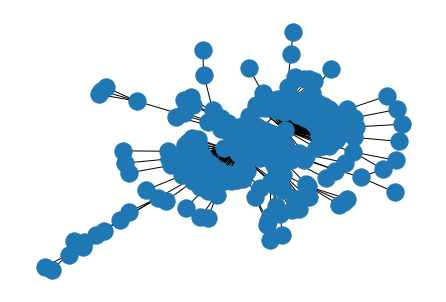

In [47]:
import networkx as nx
from torch_geometric.utils import *
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
print(N)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)

In [48]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='https://plotly.com/python/v3/3d-network-graph/</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

In [49]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

In [50]:
#modelo(data.x, data.edge_index, data.batch)
correct = 0
print(grafo_init.y)
pred, mc_loss, o_loss = model(grafo_init.x, grafo_init.edge_index, grafo_init.batch)
#print(next(model.parameters()).device)
#print(data.x.device)
loss = F.nll_loss(pred, grafo_init.y.view(-1)) + mc_loss + o_loss
correct += pred.max(dim=1)[1].eq(grafo_init.y.view(-1)).sum().item()
print(correct/1)
print(model.new_adj.squeeze(0))
print(model.new_adj.squeeze(0).shape,"aristas orginales = ",grafo_init.edge_index.size(1))
print((model.new_adj.squeeze(0)>model.new_adj.squeeze(0).mean() + torch.std(model.new_adj.squeeze(0))).nonzero().shape)
new_edges=(model.new_adj.squeeze(0)> model.new_adj.squeeze(0).mean()+ torch.std(model.new_adj.squeeze(0))).transpose(0,1).nonzero()
print("Aristas despues del rewring",new_edges.size(0))
#print(model.edge_rewiring.shape)
#print((model.edge_rewiring.squeeze(0)!=0).sum())
#print(model.edge_rewiring.squeeze(0))
#print((model.edge_rewiring.squeeze(0).nonzero()).transpose(0,1).numpy().shape)
#kk = model.edge_rewiring.squeeze(0).nonzero().transpose(0,1)
#print(kk.size(1))
#print(model.edge_rewiring.squeeze(0))
#print((model.edge_rewiring.squeeze(0)>0.0241).nonzero())
#kk2 = (model.edge_rewiring.squeeze(0)>0.0241).nonzero().transpose(0,1)
#for k in range(kk.size(1)):
#    print("(",kk[0][k].item(),",", kk[1][k].item(),")")

tensor([0])
1.0
tensor([[0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
        [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
        [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
        ...,
        [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
        [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
        [0.0033, 0.0033, 0.0033,  ..., 0.0033, 0.0033, 0.0033]])
torch.Size([306, 306]) aristas orginales =  832
torch.Size([832, 2])
Aristas despues del rewring 832


In [51]:
print(model.new_adj.squeeze(0).mean())
print(torch.std(model.new_adj.squeeze(0)))


tensor(0.0033)
tensor(1.1986e-05)


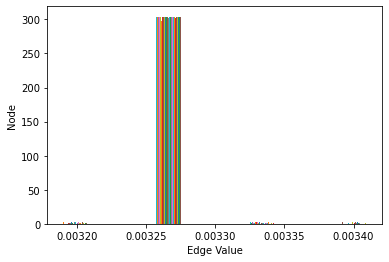

In [52]:
import matplotlib.pyplot as plt
plt.hist(model.new_adj.squeeze(0).numpy())
plt.ylabel('Node')
plt.xlabel('Edge Value')
plt.show()

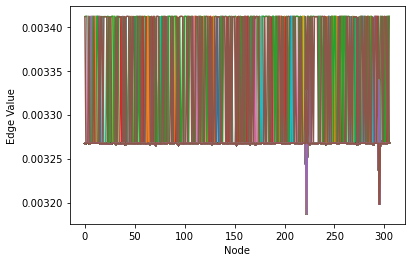

In [53]:
import matplotlib.pyplot as plt
plt.plot(model.new_adj.squeeze(0).numpy())
plt.xlabel('Node')
plt.ylabel('Edge Value')
plt.show()


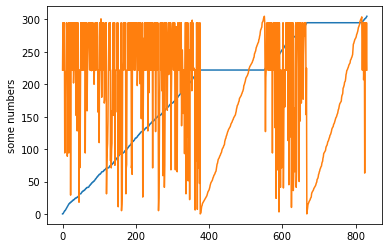

In [54]:
import matplotlib.pyplot as plt
plt.plot(new_edges)
plt.ylabel('some numbers')
plt.show()


<class 'torch.Tensor'>
DataBatch(edge_index=[2, 832], y=[1], x=[306, 1], num_nodes=306, batch=[306], ptr=[2])
DataBatch(edge_index=[2, 832], y=[1], x=[306, 1], num_nodes=306, batch=[306], ptr=[2])
<Layout with 306 vertices and 3 dimensions>
832
tensor([  0, 222])
tensor([  0, 295])
tensor([  1, 222])
tensor([  2, 222])
tensor([  3, 246])
tensor([  4, 295])
tensor([ 5, 94])
tensor([  5, 152])
tensor([  6, 214])
tensor([  7, 217])
tensor([  8, 222])
tensor([  9, 295])
tensor([ 10, 271])
tensor([11, 89])
tensor([ 12, 222])
tensor([ 13, 222])
tensor([ 14, 295])
tensor([15, 94])
tensor([ 16, 222])
tensor([ 16, 295])
tensor([ 17, 222])
tensor([ 17, 295])
tensor([18, 29])
tensor([ 18, 222])
tensor([ 19, 222])
tensor([ 19, 295])
tensor([ 20, 222])
tensor([ 20, 295])
tensor([ 21, 222])
tensor([ 21, 295])
tensor([ 22, 202])
tensor([ 22, 222])
tensor([ 22, 295])
tensor([ 23, 222])
tensor([ 24, 222])
tensor([ 24, 242])
tensor([ 24, 295])
tensor([ 25, 152])
tensor([ 25, 222])
tensor([ 25, 295])
ten

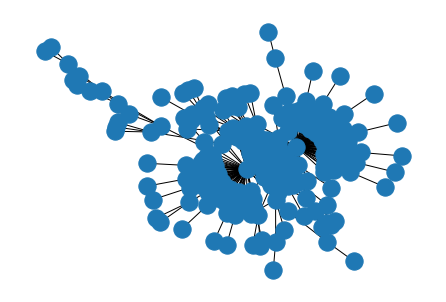

In [55]:
import networkx as nx
from torch_geometric.utils import *
print(type(grafo_init.edge_index))
print(grafo_init)
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
#A.edges = kk
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
new_Edges=[]
for ne in new_edges:
    new_Edges.append(ne)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    #print(e)
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
#EN ESTE PASO RECALCO LOS EDGES NUEVOS
Xahmed=[]
Yahmed=[]
Zahmed=[]
print(len(new_Edges))
for e in new_Edges:
    print(e)
    Xahmed+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Yahmed+=[layt[e[0]][1],layt[e[1]][1], None]
    Zahmed+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)

In [56]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(0,0,0)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
#Lo mismo de antes, estas las pinto de negro y las antiguas de blanco (una pequeña chapuza)
# Vale no, abajo explico como hacerlo sin chapuza
trace3=go.Scatter3d(x=Xahmed,
               y=Yahmed,
               z=Zahmed,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='https://plotly.com/python/v3/3d-network-graph/</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

In [57]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
#Si en data no pongo trace1(que son los antiguos edges) no me los imprime y no es una chapuza
data=[trace2,trace3]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

## All graphs embedding

# Embeddings GapNet Laplacian

In [ ]:
test_loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model =  GAPNet(dataset.num_features, dataset.num_classes, derivative="laplacian",device=device)
model.load_state_dict(torch.load("models/REDDIT-BINARY_GAPNet_laplacian_iter0.pth", map_location=torch.device('cpu')))
model.eval()

# Statistical data about the graph

In [ ]:
import networkx as nx
from torch_geometric import utils
import numpy as np
from tqdm.notebook import tqdm


nxdata = {
    'Assortativity':np.empty(len(dataset)),
    'Triangles':np.empty(len(dataset)),
    'Transitivity':np.empty(len(dataset)),
    'Clustering':np.empty(len(dataset))
}
for i, graph in enumerate(tqdm(dataset, desc='Datasets')):
    G = utils.to_networkx(graph, to_undirected=True)
    nxdata['Assortativity'][i] = nx.degree_assortativity_coefficient(G)
    nxdata['Triangles'][i] = np.sum(list(nx.triangles(G).values()))/3
    nxdata['Transitivity'][i] = nx.transitivity(G)
    nxdata['Clustering'][i] = nx.average_clustering(G)


In [ ]:
for k in nxdata:
    print(f"{k}: {nxdata[k].mean():.4f} +- {nxdata[k].std():.4f}")

# Stratify

In [ ]:
from sklearn.model_selection import train_test_split

def class_distrib(dataset):
    d = dict()
    for data in dataset:
        d[int(data.y.numpy())] = d.get(int(data.y.numpy()),0) + 1
    return d

def batch_class_distrib(batch):
    d = dict()
    for label in batch.y:
        d[int(label.numpy())] = d.get(int(label.numpy()),0) + 1
    return d

len(dataset.data.y)

In [ ]:
train_indices, val_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.2, stratify=dataset.data.y)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

In [ ]:
class_distrib(dataset), class_distrib(train_dataset), class_distrib(val_dataset)

**Optional**

In [ ]:
from torch.utils.data import SequentialSampler

In [ ]:
class StratifiedSampler():
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=0.5)
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return np.hstack([train_index, test_index])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [ ]:
sampler = StratifiedSampler(class_vector=dataset.data.y, batch_size=BATCH_SIZE)


In [ ]:
loader = DataLoader(dataset, batch_size=2, #train_dataset
                        shuffle=False, sampler=sampler)

## DIGL

In [ ]:
import scipy.sparse as sp
from torch_geometric.utils.convert import to_scipy_sparse_matrix, from_scipy_sparse_matrix
from torch_geometric.utils import dense_to_sparse

In [ ]:
from torch_geometric.transforms import BaseTransform

class DIGLedges(BaseTransform):
    def __init__(self, alpha:float, eps:float, use_edge_weigths = False):
        self.alpha = alpha
        self.eps = eps
        self.use_edge_weigths = use_edge_weigths

    def __call__(self, data):
        new_edges, new_weights = self.digl_edges(data.edge_index, self.alpha, self.eps)
        data.edge_index = new_edges
        
        if self.use_edge_weigths:
            data.edge_weight = new_weights
            
        return data
    
    
    def gdc(self, A: sp.csr_matrix, alpha: float, eps: float):
        N = A.shape[0]

        # Self-loops
        A_loop = sp.eye(N) + A

        # Symmetric transition matrix
        D_loop_vec = A_loop.sum(0).A1
        D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
        D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
        T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

        # PPR-based diffusion
        S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

        # Sparsify using threshold epsilon
        S_tilde = S.multiply(S >= eps)

        # Column-normalized transition matrix on graph S_tilde
        D_tilde_vec = S_tilde.sum(0).A1
        T_S = S_tilde / D_tilde_vec

        return T_S

    def digl_edges(self, edges, alpha, eps):
        A0 = sp.csr_matrix(to_scipy_sparse_matrix(edges))
        new_sp_matrix = sp.csr_matrix(gdc(A0, self.alpha, self.eps))
        new_edge_index, weights = from_scipy_sparse_matrix(new_sp_matrix)
        return new_edge_index, weights
    
    
    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.alpha})'
    
    

In [ ]:
digl_data = TUDataset(root='data/digl/TUDataset',name='MUTAG', transform=DIGLedges(0.5, 0.02))

In [ ]:
digl_data[0].edge_index

In [ ]:
dataset[0].edge_index

In [ ]:
digl_data = TUDataset(root='data/digl/TUDataset',name='MUTAG')

In [ ]:
digl_data[0].edge_index